In [61]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import itertools
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [62]:
device = 'cuda'

In [63]:
batch_size=128

In [64]:
train = torchvision.datasets.MNIST('../../dataset', train=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('../../dataset', train=False, transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(
            train,
            batch_size=batch_size,
            shuffle=True,

)

test_dataloader = torch.utils.data.DataLoader(
            test,
            batch_size=batch_size,
            shuffle=False,
)

In [65]:
img_size=28
hidden_dim=400
latent_dim=16

In [66]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

In [67]:
class Encoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Encoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = self.fc2(self.fc1(x))

        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))

        z = reparameterization(mu, logvar)
        return z, mu, logvar

In [68]:
class Decoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Decoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.fc3 = nn.Linear(h_dim, x_dim)

    def forward(self, z):
        z = self.fc2(self.fc1(z))
        x_reconst = F.sigmoid(self.fc3(z))
        return x_reconst

In [74]:
lr = 10**-3
n_epochs = 300

In [70]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr
)

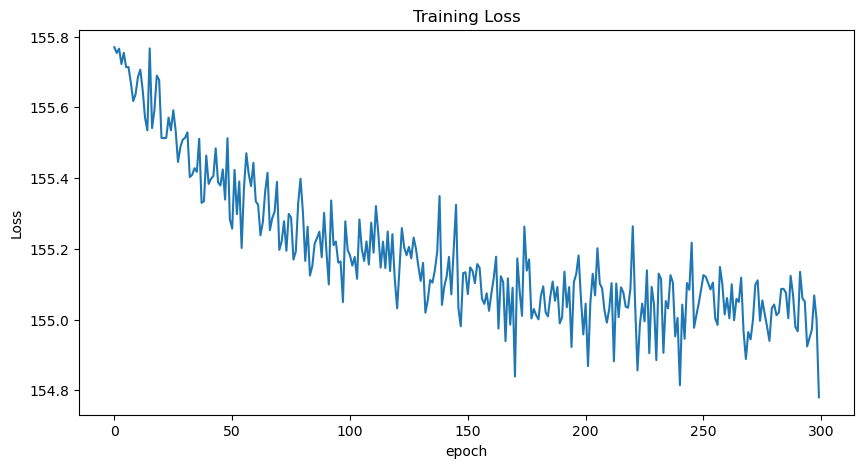

In [75]:
losses = []
for epoch in range(n_epochs):
    train_loss = 0
    for i, (x, _) in enumerate(train_dataloader):
        # forward
        x = x.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = encoder(x)
        x_reconst = decoder(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 10 == 0:
            pass
            #print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_dataloader)}], Reconst Loss : {reconst_loss.item():.4f}, KL Div: {kl_div.item():.4f}')

    print(f'===> Epoch: {epoch+1} Average Train Loss: {train_loss/len(train_dataloader.dataset):.4f} ')
    losses.append(train_loss/len(train_dataloader.dataset))
    
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_dataloader):
            # forward
            x = x.view(-1, img_size**2)
            x = x.to(device)
            z, mu, logvar = encoder(x)
            x_reconst = decoder(z)

            # compute reconstruction loss and KL divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

            loss = reconst_loss + kl_div
            test_loss += loss.item()

            # save reconstruction images
            if i==0:
                x_concat = torch.cat([x.view(-1, 1, 28, 28), x_reconst.view(-1, 1, 28, 28)], dim=3)
                # batch size 개수만큼의 이미지 쌍(input x, reconstructed x)이 저장됨
                save_image(x_concat, 'VAE_reconst.png')

        print(f'===> Epoch: {epoch+1} Average Test Loss: {test_loss/len(test_dataloader.dataset):.4f} ')
        
        # save sampled images
        z = torch.randn(batch_size, latent_dim).to(device) # N(0, 1)에서 z 샘플링
        sampled_images = decoder(z)
        save_image(sampled_images.view(-1, 1, 28, 28), 'VAE_sampled.png')
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()


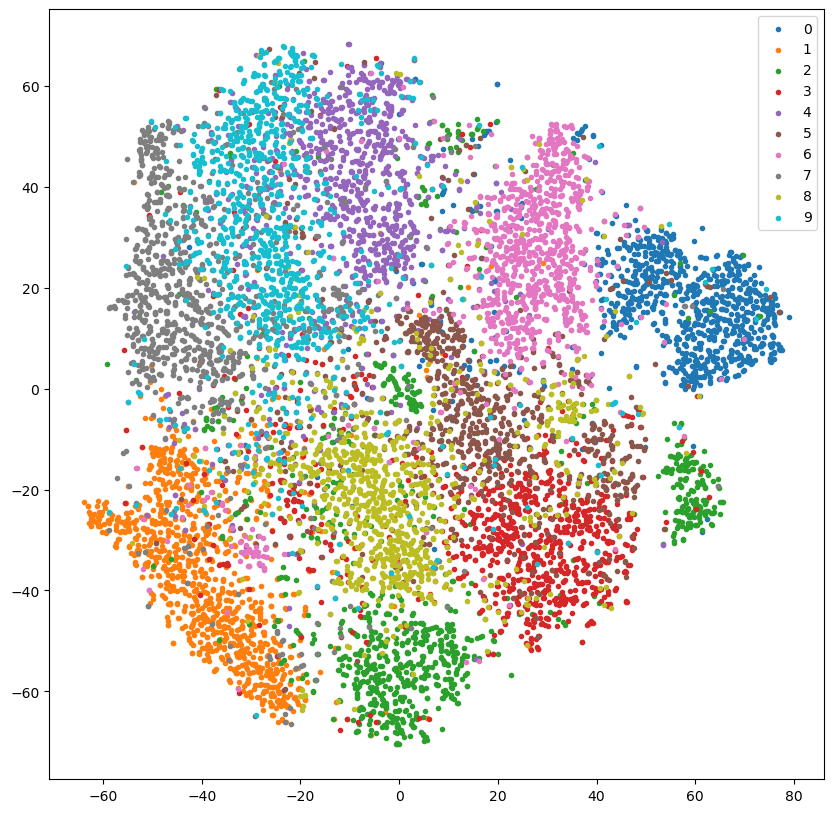

In [76]:
latent_lists = []
label_lists = []

import numpy as np
from sklearn.manifold import TSNE
with torch.no_grad():
	for data in test_dataloader:
		data[0] = data[0].view(-1, img_size**2)
		images, labels = data[0].to(device), data[1].to(device)
		features, _, _ = encoder(images)

		latent_lists += features.cpu().numpy().tolist()
		label_lists += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(latent_lists)))
actual = np.array(label_lists)

plt.figure(figsize=(10, 10))
cifar = [i for i in range(10)]
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()